```{index} single: application; portfolio
```
```{index} single: application; investment
```
```{index} single: solver; cbc
```
```{index} single: solver; highs
```
```{index} pandas dataframe
```
```{index} web scraping
```

# Mean Absolute Deviation (MAD) portfolio optimization

Portfolio optimization and modern portfolio theory has a long and important history in finance and investment. The principal idea is to find a blend of investments in financial securities that achieves  an optimal trade-off between financial risk and return. The introduction of modern portfolio theory is generally attributed to the 1952 doctoral thesis of [Harry Markowitz](https://en.wikipedia.org/wiki/Harry_Markowitz) who subsequently was award a share of the 1990 Nobel Memorial Prize in Economics for his fundamental contributions to this field. The well-known "Markowitz Model" models measure risk using covariance of the portfolio with respect to constituent assets, then solves a minimum variance problem by quadratic optimization problem subject to constraints to allocate of wealth among assets.

In a [remarkable 1991 paper](https://www.jstor.org/stable/2632458?seq=1), Konno and Yamazaki proposed a different approach using the mean absolute deviation (MAD) in portfolio return as a measure of financial risk. The proposed implementation directly incorporates historical price data into a large scale linear optimization problem. 

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and HiGHS, then sets SOLVER to 
use the Highs solver via the appsi module. If run elsewhere, it assumes Pyomo and CBC
have been previously installed and sets SOLVER to use the CBC solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null

    from pyomo.contrib import appsi
    SOLVER = appsi.solvers.Highs(only_child_vars=False)
    
else:
    from pyomo.environ import SolverFactory
    SOLVER = SolverFactory('cbc')

assert SOLVER.available(), f"Solver {SOLVER} is not available."

### Installing `yfinance`

The notebook uses the `yfinance` module to read data from Yahoo Finance. Web interfaces for financial services are notoriously fickle and subject to change, and a particular issue with Google Colaboratory.

In [2]:
!pip install yfinance --upgrade -q

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as datetime
import yfinance as yf

### Download historical stock price data

The following cell downloads a list of stock symbols from Yahoo Finance. By changing `n_years` we can change the historical period. The first step in this analysis is to load and consolidate the asset price information into a single DataFrame named `assets`. The consolidated price information consists of the adjusted closing price reported by Yahoo Finance which includes adjustments for stock splits and dividend distributions.

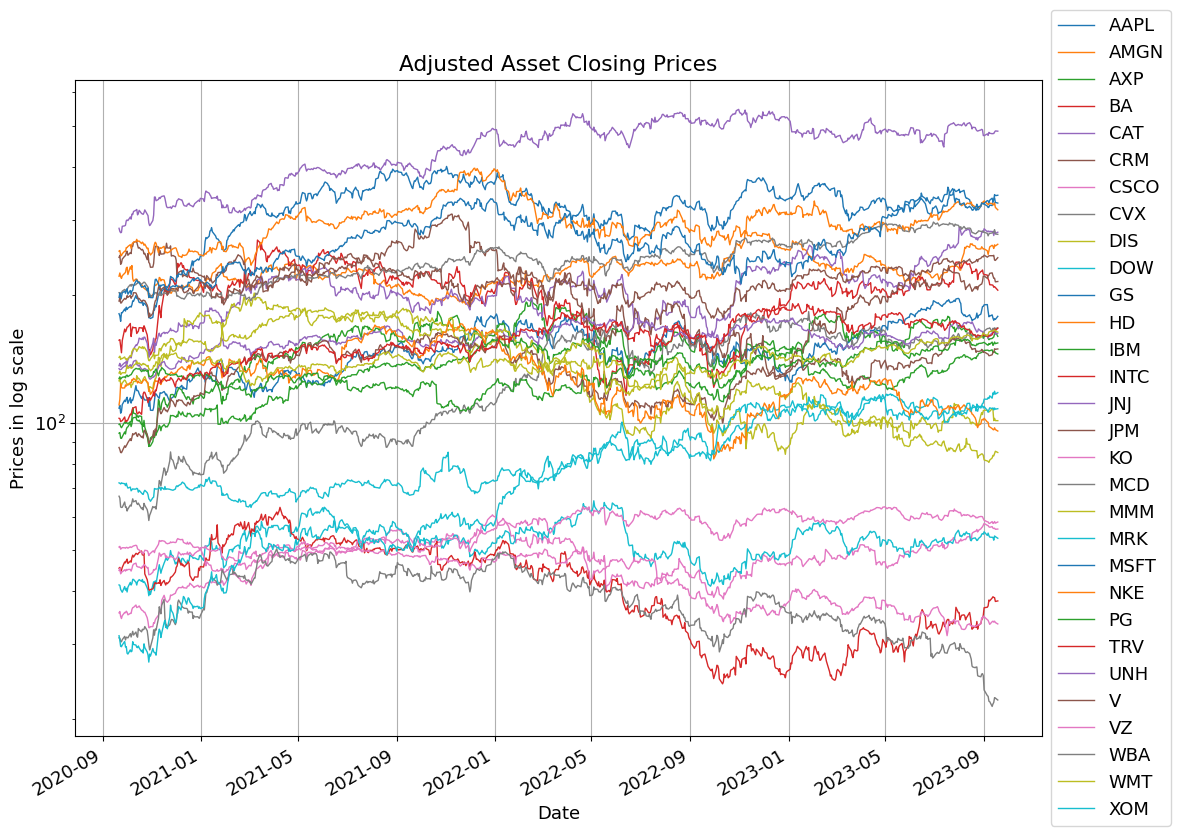

In [15]:
# list of stock symbols
tickers = ['AXP', 'AAPL', 'AMGN', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', \
         'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
         'MSFT', 'NKE', 'PG','TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM']

n_years = 3.0
end_date = datetime.datetime.today().date()
start_date = end_date - datetime.timedelta(round(n_years*365))

assets = yf.download(tickers, start=start_date, end=end_date, progress=False)["Adj Close"]

assets.fillna(method="bfill", inplace=True)
assets.fillna(method="ffill", inplace=True)

fig, ax = plt.subplots(figsize=(12, 9))
assets.plot(ax=ax, logy=True, grid=True, lw=1, title="Adjusted Asset Closing Prices")
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Prices in log scale")
plt.tight_layout()
plt.show()

## Analysis of historical asset prices

### Scaled asset prices

The historical prices are scaled to a value to have unit value at the start of the historical period. Scaling facilitates plotting and subsequent calculations while preserving arithmetic and logarithmic returns needed for analysis. 

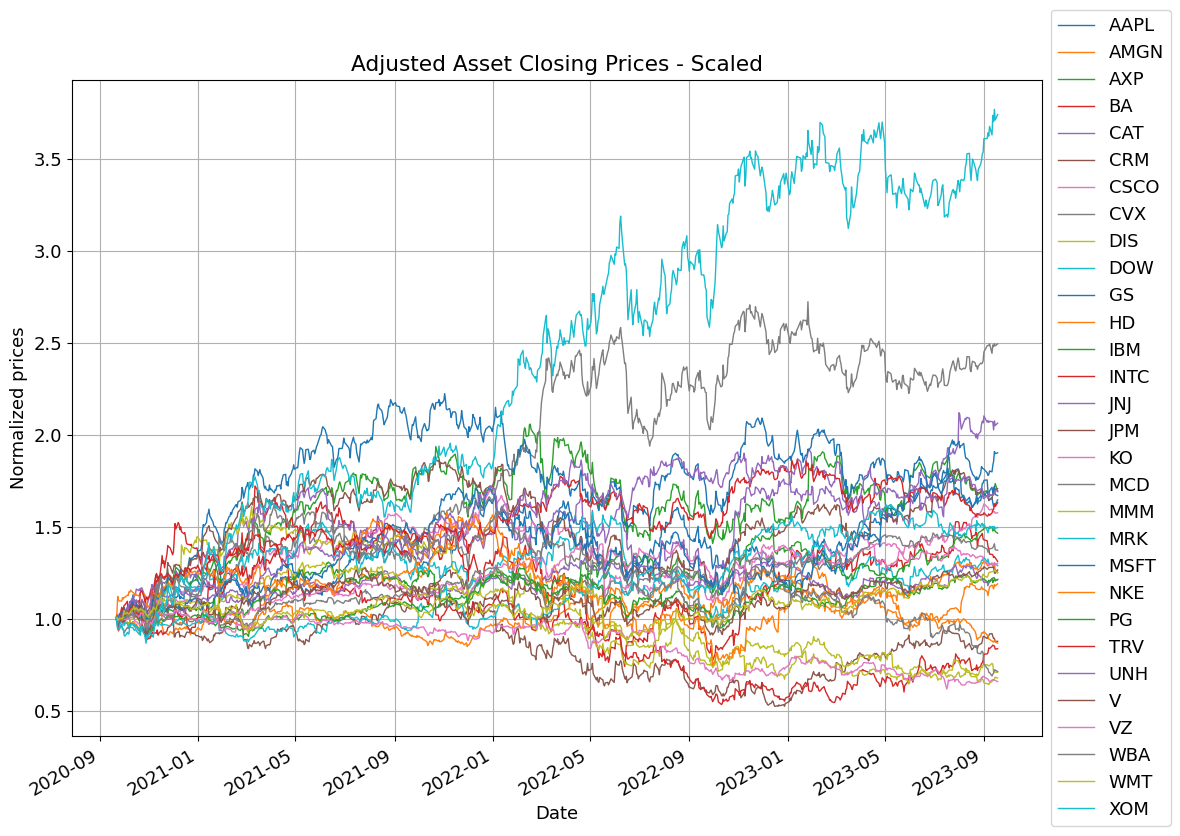

In [16]:
assets_scaled = assets.div(assets.iloc[0])

fig, ax = plt.subplots(figsize=(12, 9))
assets_scaled.plot(ax=ax, grid=True, lw=1, title="Adjusted Asset Closing Prices - Scaled")
ax.legend(bbox_to_anchor=(1.0, 1.12))
ax.set_ylabel("Normalized prices")
plt.rcParams['font.size'] = 13
plt.tight_layout()
plt.show()

### Statistics of daily returns

The scaled price of asset $j$ on trading day $t$ is designated $S_{j, i}$. The daily return is computed as

$$r_{j, t} = \frac{S_{j, t} - S_{j, t-1}}{S_{j, t-1}}$$

where $t = 1, \dots, T$. The mean return for asset $j$ is 

$$\bar{r}_j = \frac{1}{T} \sum_{t=1}^T r_{j, t}$$

The following cells compute and display the daily returns for all assets and displays as time series and histograms.

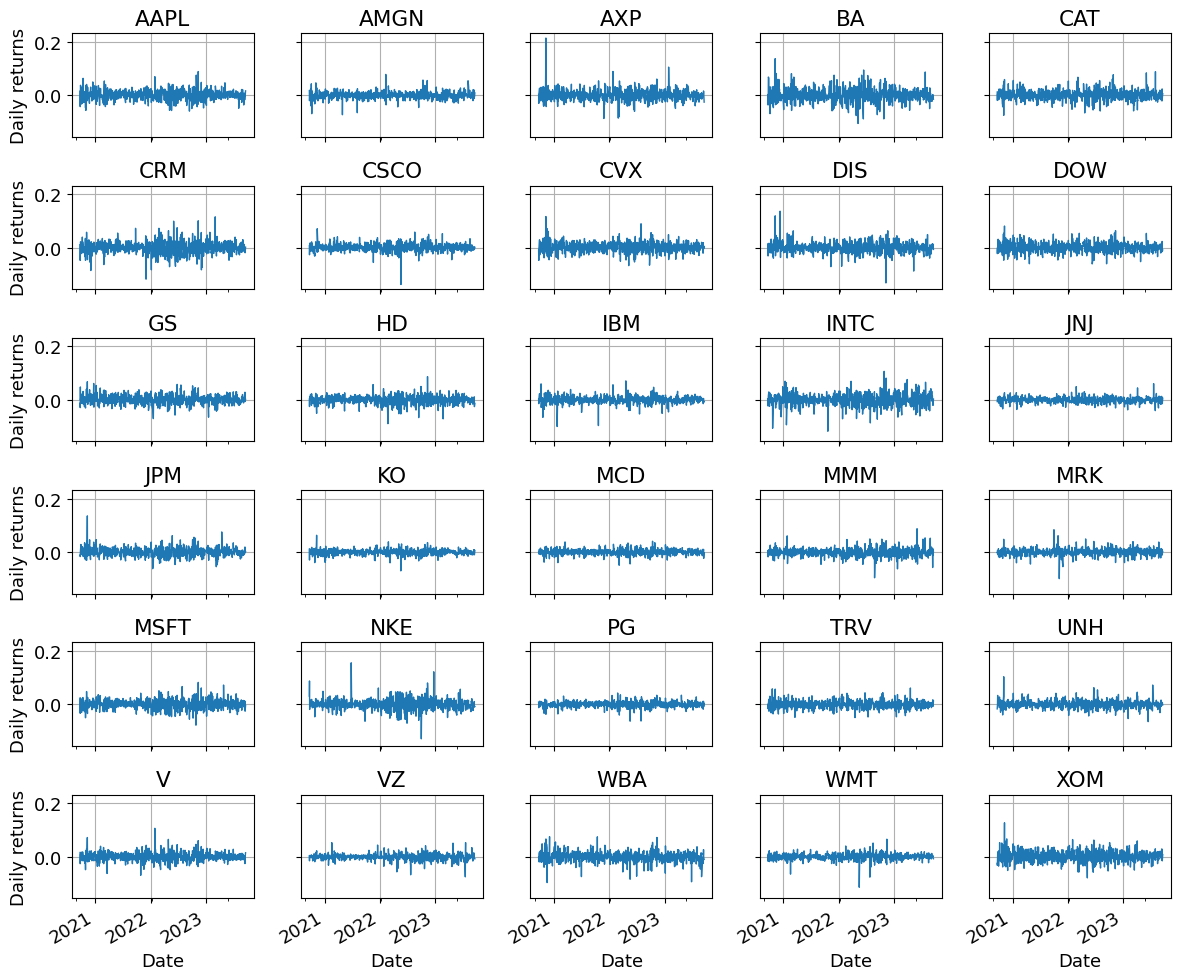

In [17]:
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)

for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)
    a.xaxis.set_major_locator(mdates.YearLocator())
    a.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    a.set_ylabel("Daily returns")
    
plt.tight_layout()
plt.show()

### Mean Absolute Deviation

The mean absolute deviation $\Delta_j$ for asset $j$ is 

$$\Delta_j = \frac{1}{T} \sum_{t=1}^T | r_{j,t} - \bar{r}_j |$$

where $T$ is the period under consideration. We now calculate the mean daily return and the mean absolute deviation in daily returns for all assets and display the distributions of daily returns for all assets. For each asset, we depict the mean return $\bar{r}$ (in red) and the interval $[\bar{r}-\Delta,\bar{r}+\Delta]$ whose size corresponds to its mean absolute deviation (in green).

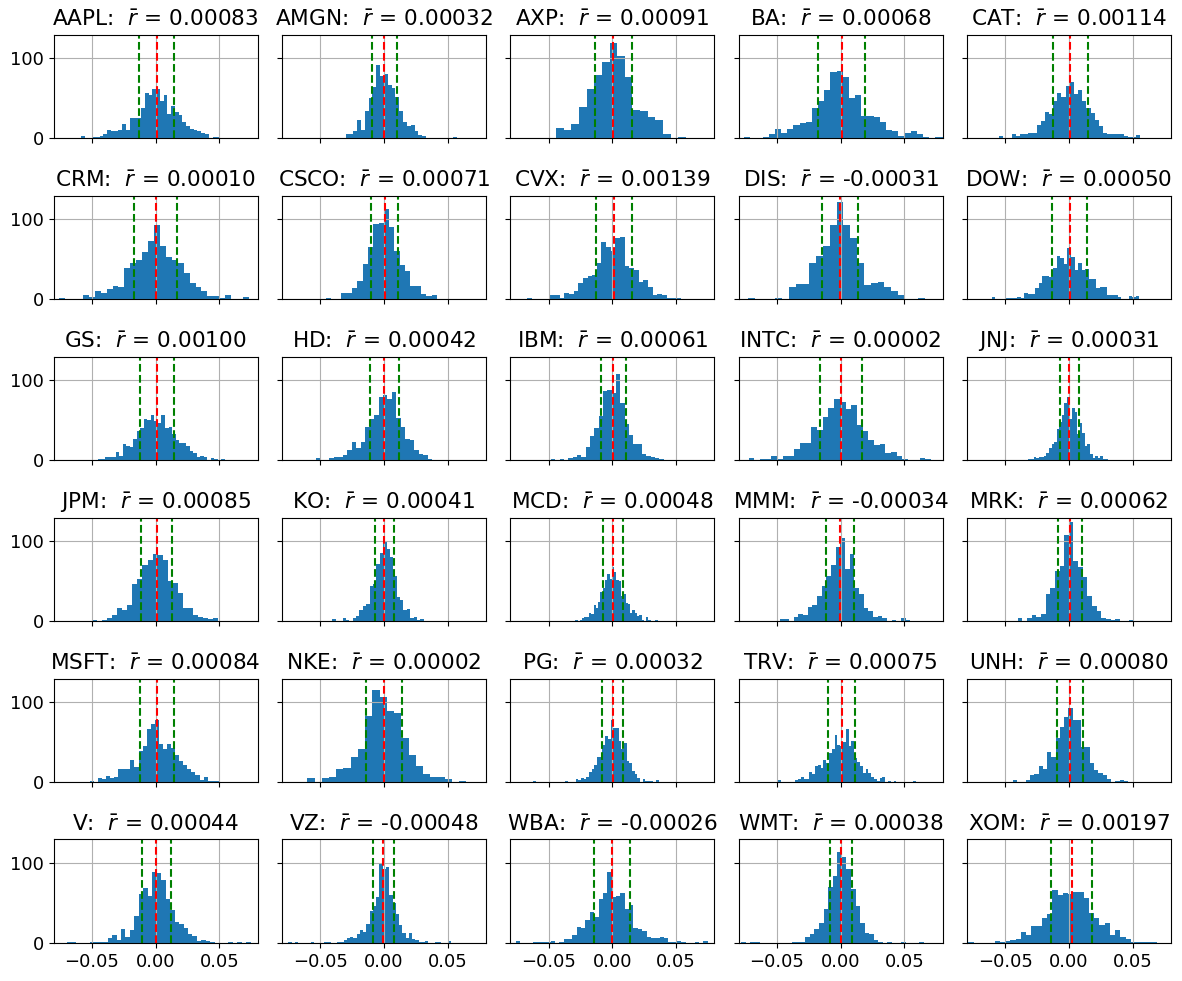

In [19]:
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    a.set_title(f"{s}:  $\\bar r$ = {mean_return[s]:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return[s], color='r', linestyle="--")
    a.axvline(mean_return[s] + mean_absolute_deviation[s], color='g', linestyle='--')
    a.axvline(mean_return[s] - mean_absolute_deviation[s], color='g', linestyle='--')
    
plt.tight_layout()
plt.show()

The mean daily return and the mean absolute deviation in daily returns are plotted as bar charts in the following cell. The side by side comparison provides a comparison of return vs. volatility for individual assets.

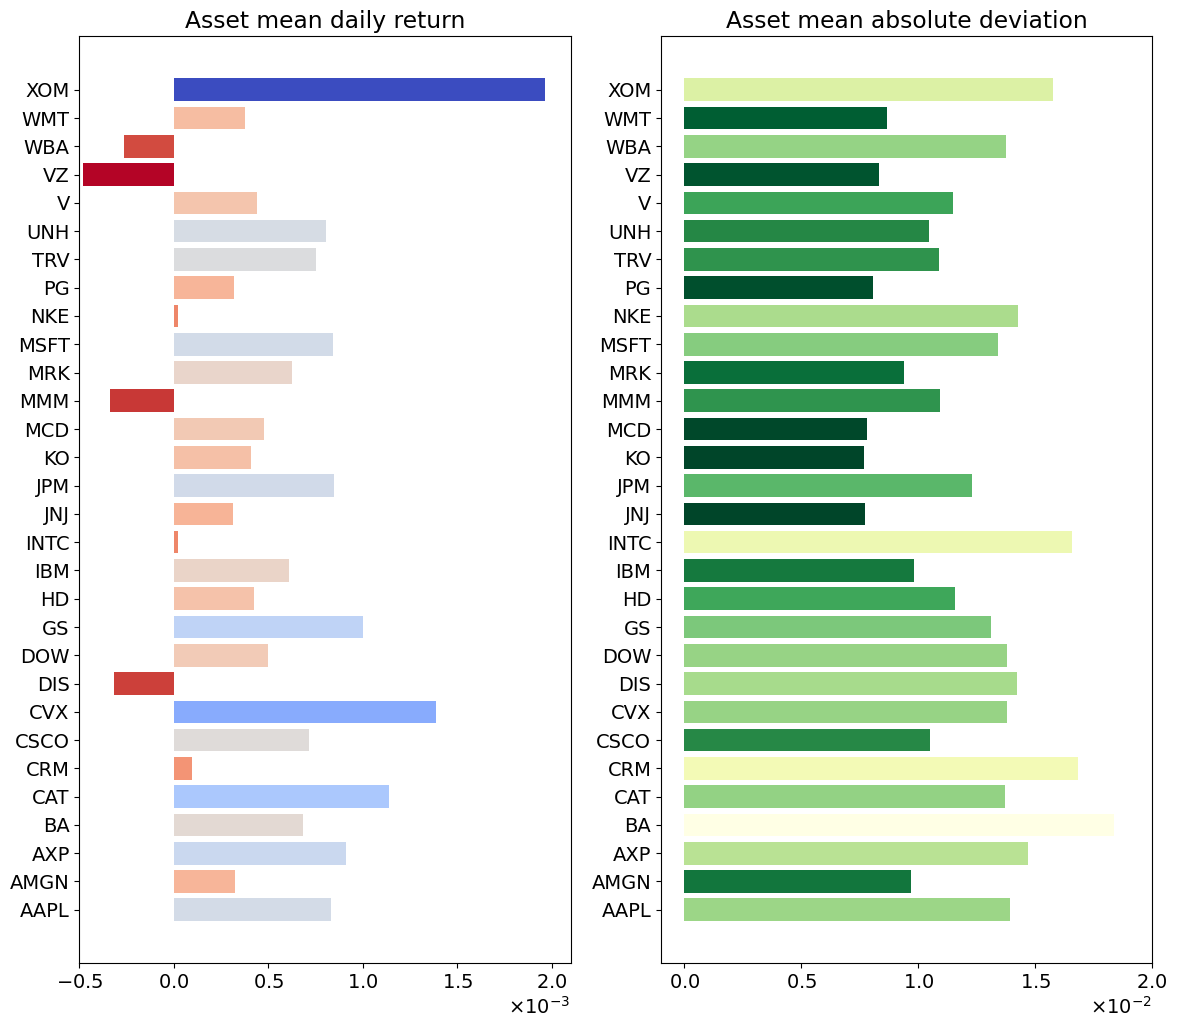

In [21]:
from matplotlib.ticker import ScalarFormatter

def gradient_barplot(ax, data, color_map):
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val
    
    for i, val in enumerate(data):
        normalized_val = (val - min_val) / range_val
        color = color_map(normalized_val)
        ax.barh(i, val, color=color)

fig, ax = plt.subplots(1, 2, figsize=(12, 0.35 * len(daily_returns.columns)))

# Choose the color maps
color_map2 = plt.get_cmap('coolwarm').reversed()
color_map3 = plt.get_cmap('YlGn').reversed()

# Asset mean daily return
gradient_barplot(ax[0], mean_return, color_map2)
ax[0].set_title("Asset mean daily return")
ax[0].set_yticks(np.arange(len(mean_return)))
ax[0].set_yticklabels(mean_return.index)
ax[0].set_xlim(-0.0005, 0.0021)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax[0].xaxis.set_major_formatter(formatter)

# Asset mean absolute deviation
gradient_barplot(ax[1], mean_absolute_deviation, color_map3)
ax[1].set_title("Asset mean absolute deviation")
ax[1].set_yticks(np.arange(len(mean_absolute_deviation)))
ax[1].set_yticklabels(mean_absolute_deviation.index)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))
ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_xlim(-0.001, 0.02)

plt.tight_layout()
plt.show()

We now plot the mean return and mean absolute deviation for all assets using a scatter plot. The scatter plot provides a visual comparison of the trade-off between return and volatility for individual assets.

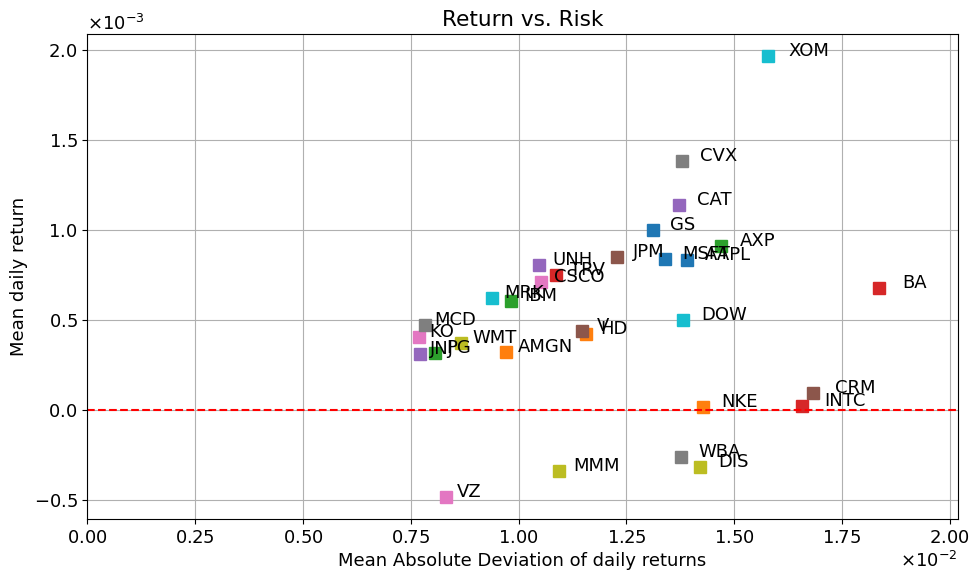

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1*mean_absolute_deviation.max())
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs. Risk')
ax.set_xlabel('Mean Absolute Deviation of daily returns')
ax.set_ylabel('Mean daily return')
ax.grid(True)
plt.tight_layout()
plt.show()

## Analysis of a portfolio of assets

### Return on a portfolio

Given a portfolio with value $W_t$ at time $t$, return on the portfolio at $t_{t +\delta t}$ is defined as

$$
\begin{align*}
r_{t + \delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}}
\end{align*}
$$

For the period from $[t, t+\delta t)$ we assume there are $n_{j,t}$ shares of asset $j$ with a starting value of $S_{j,t}$ per share. The initial and final values of the portfolio are then 

$$
\begin{align*}
W_t & = \sum_{j=1}^J n_{j,t}S_{j,t} \\
W_{t+\delta t} & = \sum_{j=1}^J n_{j,t}S_{j,t + \delta t}
\end{align*}
$$

The return of the portfolio is given by

$$
\begin{align*}
r_{t+\delta t} & = \frac{W_{t + \delta t} - W_{t}}{W_{t}} \\
& = \frac{\sum_{j=1}^Jn_{j,t}S_{j,t+\delta t} - \sum_{j=1}^J n_{j,t}S_{j,t}}{W_{t}} \\
& = \frac{\sum_{j=1}^J n_{j,t}S_{j,t}r_{j, t+\delta t}}{W_{t}} \\
& = \sum_{j=1}^J \frac{n_{j,t}S_{j,t}}{W_{t}} r_{j, t+\delta t}
\end{align*}
$$

where $r_{j,t+\delta t}$ is the return on asset $j$ at time $t+\delta t$. 

Defining $W_{j,t} = n_{j,t}S_{j,t}$ as the wealth invested in asset $j$ at time $t$, then $w_{j,t} = n_{j,t}S_{j,t}/W_{t}$ is the fraction of total wealth invested in asset $j$ at time $t$. The return on a portfolio of $J$ assets is then given by 

$$
\begin{align*}
r_{t+\delta t} & = \sum_{j=1}^J w_{j,t} r_{j, t+\delta t} 
\end{align*}
$$

on a single interval extending from $t$ to $t + \delta t$.

## Mean Absolute Deviation (MAD) portfolio optimization

The portfolio optimization problem is to find an allocation of investments weights $w_j$ to minimize the portfolio measure of risk subject to constraints on required return and any other constraints that an investor wishes to impose. Assume that we can make investment decisions on every trading day $t$ over a fixed time horizon ranging from $t=1,\dots,T$ and that there is a set of $J$ assets in which we can choose to invest.

If we want to have a guaranteed minimum portfolio return $R$, but at the same time minimize risk, we could choose to have the mean absolute deviation (MAD) in portfolio returns as the objective function. More specifically, we can consider the return on a portfolio of $J$ assets over a period of $T$ intervals with weights $w_j$ for asset $j$ given by

$$
\begin{align*}
\text{MAD}(w) & =  \frac{1}{T} \sum_{t=1}^T \Big| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \Big|,
\end{align*}
$$

where $r_{t, j}$ is the return on asset $j$ at time $t$, $\bar{r}_j$ is the mean return for asset $j$, and $w_j$ is the fraction of the total portfolio that is invested in asset $j$. Note that due to the use of absolute values, the MAD for the portfolio is *not* the weighted sum of the MADs for individual assets.

The resulting Mean Absolute Deviation (MAD) portfolio optimization problem then is

$$
\begin{align*}
    \min \quad & \frac{1}{T} \sum_{t=1}^T \Big| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \Big| \\
    \text{s.t.} \quad 
    & \sum_{j=1}^J w_j \bar{r}_j  \geq R \\
    & \sum_{j=1}^J w_j  = 1 \\
    & w_j  \geq 0 & \forall \, j\in J\\
    & w_j  \leq w^{ub}_j & \forall \, j\in J.
\end{align*}
$$

where $R$ is the minimum required portfolio return. The lower bound $w_j \geq 0$ is a "no short sales" constraint. The upper bound $w_j \leq w^{ub}_j$ enforces a required level of diversification in the portfolio. 

Defining two sets of auxiliary variables $u_t \geq 0$ and $v_t \geq 0$ for every $t=1,\dots,T$, leads to a reformulation of the problem as a linear optimization:

$$
\begin{align*}
    \min \quad & \frac{1}{T} \sum_{t=1}^T (u_t + v_t) \\
    \text{s.t.} \quad 
    & u_t - v_t  = \sum_{j=1}^J w_j(r_{t,j} - \bar{r}_j) & \forall t\in 1, \dots, T \\
    & \sum_{j=1}^J w_j \bar{r}_j  \geq R \\
    & \sum_{j=1}^J w_j = 1 \\
    & w_j  \geq 0 & \forall \, j\in J\\
    & w_j  \leq w^{ub}_j & \forall \, j\in J\\
    & u_t, v_t \geq 0 &t = 1, \dots, T.
\end{align*}
$$


### Pyomo model

In [46]:
import pyomo.environ as pyo

def mad_portfolio(assets):
    
    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel("MAD portfolio optimization")
    
    m.R = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)
    
    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))
    
    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME)/len(m.TIME)
    
    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t-1]
        return m.u[t] - m.v[t] == sum(m.w[j]*(daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS)
    
    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) == 1
    
    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * mean_return[j] for j in m.ASSETS) >= m.R
    
    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb
    
    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub
    
    return m
    
m = mad_portfolio(assets)

m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
SOLVER.solve(m)

print(f"Weight lower bound                 {m.w_lb():0.3f}")
print(f"Weight upper bound                 {m.w_ub():0.3f}")
print(f"Optimal weights:                   {[round(m.w[j](), 3) if round(m.w[j](), 3) != 0 else 0 for j in m.ASSETS]}")
print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
print(f"Required portfolio daily return    {m.R():0.3f}")
print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.3f}")
print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

Weight lower bound                 0.000
Weight upper bound                 0.200
Optimal weights:                   [0, 0, 0, 0, 0.059, 0, 0, 0.078, 0, 0, 0, 0, 0.007, 0, 0, 0, 0, 0.155, 0, 0.138, 0.144, 0, 0.019, 0.003, 0.149, 0, 0, 0, 0.048, 0.2]
Fraction of portfolio invested     1.000
Required portfolio daily return    0.001
Portfolio mean daily return        0.001
Portfolio mean absolute deviation  0.00738


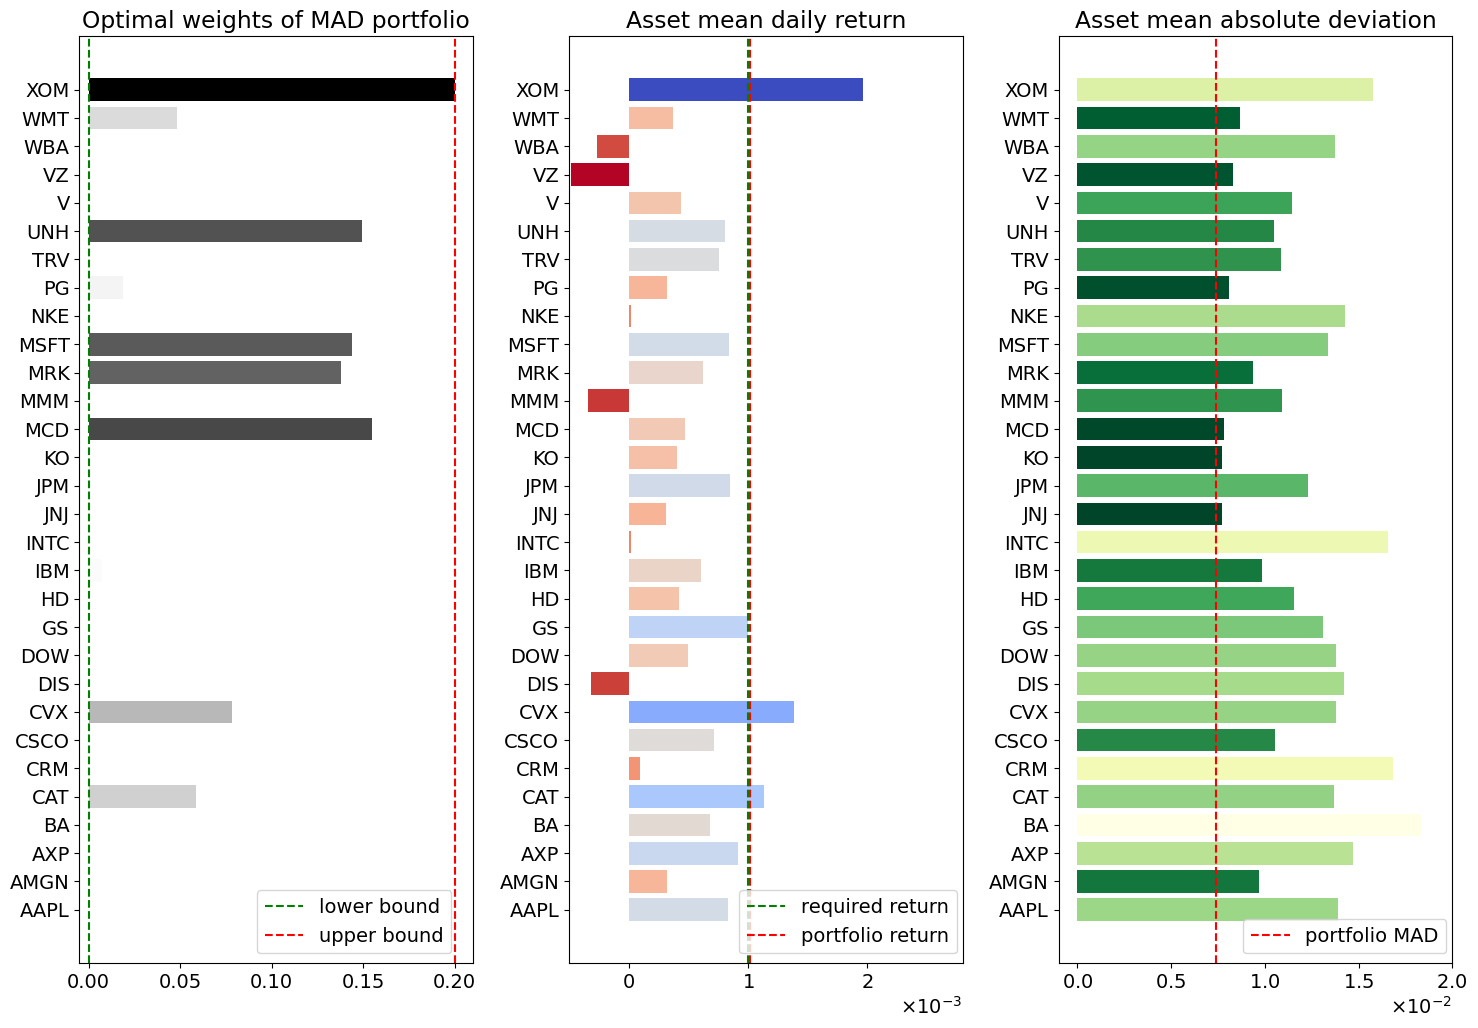

In [47]:
def mad_visualization(assets, m):

    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = pd.DataFrame([m.w[j]() for j in sorted(m.ASSETS)], index=sorted(m.ASSETS)) 

    plt.rcParams['font.size'] = 14
    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(daily_returns.columns)))

    # Choose the color maps
    color_map1 = plt.get_cmap('Greys')
    color_map2 = plt.get_cmap('coolwarm').reversed()
    color_map3 = plt.get_cmap('YlGn').reversed()

    # MAD Portfolio Optimal Weights
    gradient_barplot(ax[0], mad_portfolio_weights[0], color_map1)
    ax[0].set_title("Optimal weights of MAD portfolio")
    ax[0].set_yticks(np.arange(len(mad_portfolio_weights)))
    ax[0].set_yticklabels(mad_portfolio_weights.index)
    ax[0].axvline(m.w_lb(), ls='--', color='g')
    ax[0].axvline(m.w_ub(), ls='--', color='r')
    ax[0].legend(["lower bound", "upper bound"], bbox_to_anchor=(0.97, 0), loc='lower right')
    ax[0].set_xlim(-0.005, 0.21)

    # Asset mean daily return
    gradient_barplot(ax[1], mean_return, color_map2)
    ax[1].set_title("Asset mean daily return")
    ax[1].set_yticks(np.arange(len(mean_return)))
    ax[1].set_yticklabels(mean_return.index)
    ax[1].axvline(m.R(), ls='--', color='g')
    ax[1].axvline(m.mean_portfolio_return() + 0.000015, ls='--', color='r')
    ax[1].legend(['required return', 'portfolio return'], bbox_to_anchor=(1.01, 0), loc='lower right')
    ax[1].set_xlim(-0.0005, 0.0028)

    # Formatter
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[1].xaxis.set_major_formatter(formatter)

    # Asset mean absolute deviation
    gradient_barplot(ax[2], mean_absolute_deviation, color_map3)
    ax[2].set_title("Asset mean absolute deviation")
    ax[2].set_yticks(np.arange(len(mean_absolute_deviation)))
    ax[2].set_yticklabels(mean_absolute_deviation.index)
    ax[2].axvline(m.MAD(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"], bbox_to_anchor=(1.01,0), loc='lower right')

    # Formatter
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax[2].xaxis.set_major_formatter(formatter)
    ax[2].set_xlim(-0.001, 0.02)

    plt.tight_layout()
    plt.show()

mad_visualization(assets, m)

### MAD risk versus return

The portfolio optimization problem has been formulated as the minimization of a risk measure, MAD, subject to a lower bound $R$ on mean portfolio return. Increasing the required return for the portfolio therefore comes at the cost of tolerating a higher level of risk. Finding the optimal trade off between risk and return is a central aspect of any investment strategy.

The following cell creates a plot of the risk/return trade off by solving the MAD portfolio optimization problem for increasing values of required return $R$. This should be compared to the similar construction commonly used in presentations of the portfolio optimization problem due to Markowitz.

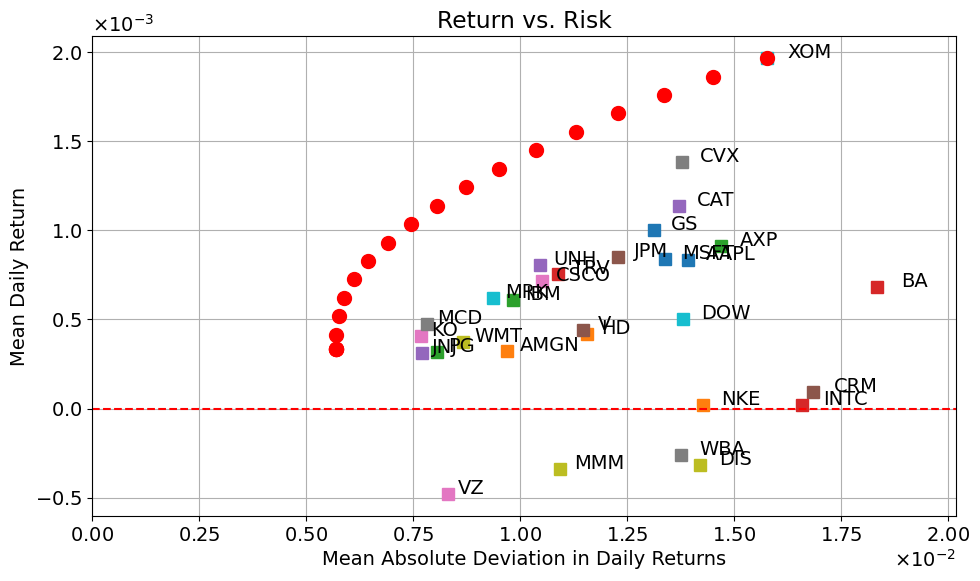

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)
    
ax.set_xlim(0, 1.1*max(mean_absolute_deviation))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs. Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

m = mad_portfolio(assets)
for R in np.linspace(0, mean_return.max(), 20):
    m.R = R
    SOLVER.solve(m)
    mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))

    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, 'ro', ms=10)

plt.tight_layout()
plt.show()

### Addition of a Risk-free Asset

The option of a holding a risk-free asset as a component of investment can substantially reduce financial risk. The risk-free asset is designated as $j=0$ with a fixed return $\bar{r}_0$. The fraction invested in asset $j=0$ will be $w_0 = 1 - \sum_{j=1}^J w_j$. The optimization model becomes

$$
\begin{align*}
\min \quad & \frac{1}{T} \sum_{t=1}^T \Big| \sum_{j=1}^J w_{j} (r_{t, j} - \bar{r}_j) \Big| \\
\text{s.t.} \quad 
    & \sum_{j=1}^J w_j (\bar{r}_j - \bar{r}_0) \geq R - \bar{r}_0 \\
    & \sum_{j=1}^J w_j \leq 1 \\
    & w_j \geq 0 & \forall j\in 1,\dots, J \\
    & w_j \leq w^{ub}_j & \forall j\in 1, \dots, J.
\end{align*}
$$

Like for the original MAD portfolio optimization problem, also this one can be reformulated as an LO:

$$
\begin{align*}
\min \quad & \frac{1}{T} \sum_{t=1}^T (u_t + v_t) \\
\text{s.t.} \quad 
    & u_t - v_t = \sum_{j=1}^J w_j(r_{t,j} - \bar{r}_j) & \forall t\in 1, \dots, T \\
    & \sum_{j=1}^J w_j (\bar{r}_j - \bar{r}_0) \geq R - \bar{r}_0 \\
    & \sum_{j=1}^J w_j \leq 1 \\
    & w_j \geq 0 & \forall j\in 1,\dots, J \\
    & w_j \leq w^{ub}_j & \forall j\in 1, \dots, J \\
    & u_t, v_t \geq 0 & \forall t\in 1, \dots, T.
\end{align*}
$$

Weight lower bound                 0.000
Weight upper bound                 0.200
Optimal weights:                   [0, 0, 0, 0, 0.052, 0, 0, 0.112, 0, 0, 0.012, 0, 0, 0, 0, 0, 0, 0.085, 0, 0.13, 0.152, 0, 0, 0.011, 0.151, 0, 0, 0, 0, 0.2]
Fraction of portfolio invested     0.906
Required portfolio daily return    0.001
Portfolio mean daily return        0.001
Portfolio mean absolute deviation  0.00733


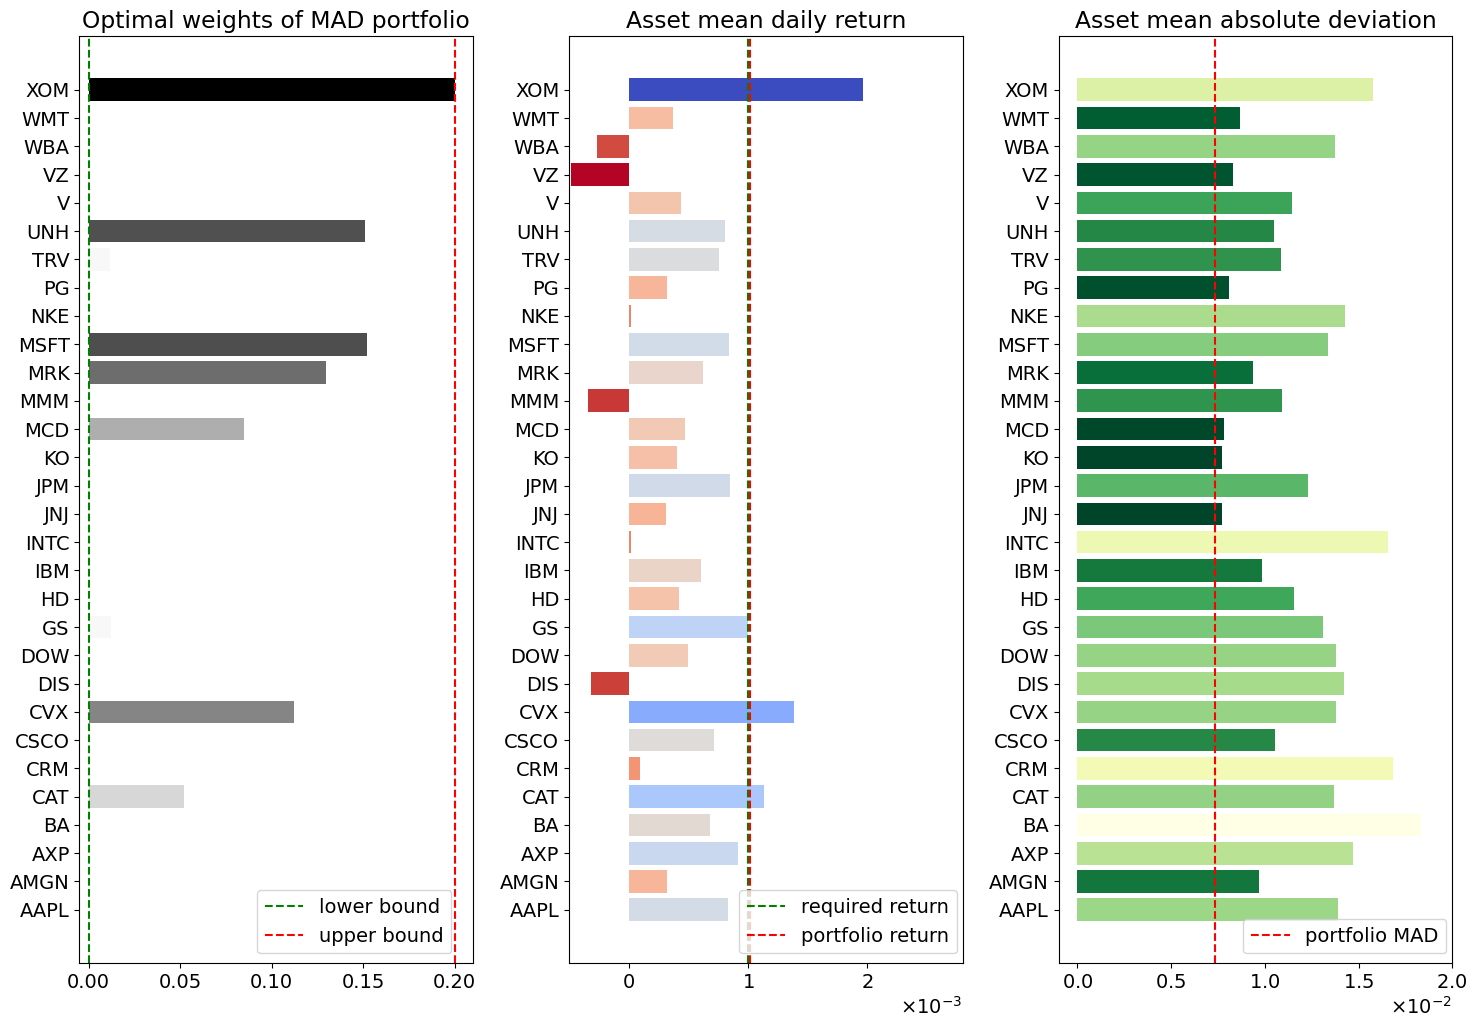

In [38]:
import pyomo.environ as pyo

def mad_portfolio_withriskfreeasset(assets):
    
    daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    m = pyo.ConcreteModel()
    
    m.R = pyo.Param(mutable=True, default=0)
    m.rf = pyo.Param(mutable=True, default=0)
    m.w_lb = pyo.Param(mutable=True, default=0)
    m.w_ub = pyo.Param(mutable=True, default=1.0)
    
    m.ASSETS = pyo.Set(initialize=assets.columns)
    m.TIME = pyo.RangeSet(len(daily_returns.index))
    
    m.w = pyo.Var(m.ASSETS)
    m.u = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    m.v = pyo.Var(m.TIME, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.u[t] + m.v[t] for t in m.TIME)/len(m.TIME)
    
    @m.Constraint(m.TIME)
    def portfolio_returns(m, t):
        date = daily_returns.index[t-1]
        return m.u[t] - m.v[t] == sum(
            m.w[j] * (daily_returns.loc[date, j] - mean_return[j]) for j in m.ASSETS)
    
    @m.Constraint()
    def sum_of_weights(m):
        return sum(m.w[j] for j in m.ASSETS) <= 1
    
    @m.Constraint()
    def mean_portfolio_return(m):
        return sum(m.w[j] * (mean_return[j] - m.rf) for j in m.ASSETS) >= m.R - m.rf
    
    @m.Constraint(m.ASSETS)
    def no_short(m, j):
        return m.w[j] >= m.w_lb
    
    @m.Constraint(m.ASSETS)
    def diversify(m, j):
        return m.w[j] <= m.w_ub
    
    return m
    
m = mad_portfolio_withriskfreeasset(assets)
m.w_lb = 0
m.w_ub = 0.2
m.R = 0.001
SOLVER.solve(m)

print(f"Weight lower bound                 {m.w_lb():0.3f}")
print(f"Weight upper bound                 {m.w_ub():0.3f}")
print(f"Optimal weights:                   {[round(m.w[j](), 3) if round(m.w[j](), 3) != 0 else 0 for j in m.ASSETS]}")
print(f"Fraction of portfolio invested     {m.sum_of_weights():0.3f}")
print(f"Required portfolio daily return    {m.R():0.3f}")
print(f"Portfolio mean daily return        {m.mean_portfolio_return():0.3f}")
print(f"Portfolio mean absolute deviation  {m.MAD():0.5f}")

mad_visualization(assets, m)

### MAD risk versus return with a risk-free asset 

As above, it is instructive to plot the MAD risk versus required return $R$. The result is similar, but not exactly the same, as  the standard presentation from modern portfolio theory (MPT) for efficient frontier of investing, and the capital market line. A careful look at the the plot below shows minor difference at very high levels of return and risk that departs from the MPT analysis. 

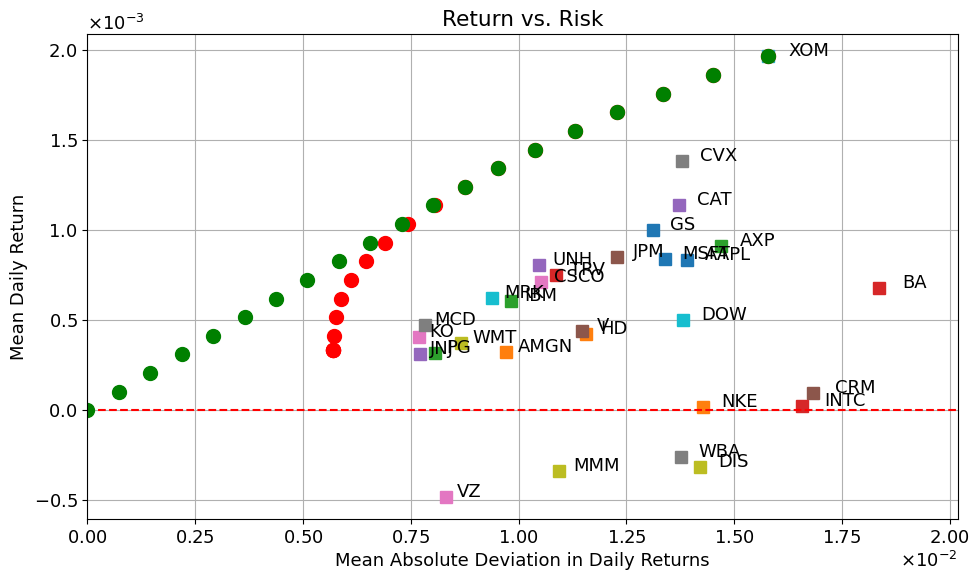

In [43]:
daily_returns = assets.diff()[1:]/assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], 's', ms=8)
    ax.text(mean_absolute_deviation[s]*1.03, mean_return[s], s)

formatterx = ScalarFormatter(useMathText=True)
formatterx.set_scientific(True)
formatterx.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatterx)
formattery = ScalarFormatter(useMathText=True)
formattery.set_scientific(True)
formattery.set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(formattery)

ax.set_xlim(0, 1.1*max(mean_absolute_deviation))
ax.axhline(0, color='r', linestyle='--')
ax.set_title('Return vs. Risk')
ax.set_xlabel('Mean Absolute Deviation in Daily Returns')
ax.set_ylabel('Mean Daily Return')
ax.grid(True)

for color, m in zip(['ro', 'go'], [mad_portfolio(assets), mad_portfolio_withriskfreeasset(assets)]):
    for R in np.linspace(0, mean_return.max(), 20):
        m.R = R
        SOLVER.solve(m)
        mad_portfolio_weights = pd.DataFrame([m.w[a]() for a in sorted(m.ASSETS)], index=sorted(m.ASSETS))
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(portfolio_returns - portfolio_mean_return).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, color, ms=10)

plt.tight_layout()
plt.show()